In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
sys.path.append("..")

from mlb_2025.utils import describe_endpoint, compile_average_player_values

load_dotenv()

from data_sources import PyBaseball, MLBStatsAPI, Salary

py_baseball = PyBaseball()
mlb_api = MLBStatsAPI()

payroll_source_paths = {
    "historical": os.getenv("MLB_PAYROLLS"),
    "recent": os.getenv("MLB_PAYROLLS_2025")
}

salary_source_paths = {
    "historical": os.getenv("MLB_PLAYER_SALARY_DATA")
}

salary = Salary(payroll_source_paths=payroll_source_paths, salary_source_paths=salary_source_paths)
payrolls = salary.payroll()

# Contains matching keys between data sources
# chadwick = py_baseball.player_search.chadwick()

### Analyze hitters for performance per salary

In [4]:
batters_stats_2025 = py_baseball.batter.stats(start_season=2025)
# Used to obtain the player salaries
bwar_keep_cols = ["name_common", "mlb_ID", "year_ID", "team_ID", "salary"]
batters_bwar_2025 = py_baseball.batter.bref_war()
batters_bwar_2025 = batters_bwar_2025[bwar_keep_cols]

2025-11-10 21:31:49,776 -    DEBUG - urllib3.connectionpool(20668) - Starting new HTTPS connection (1): www.fangraphs.com:443
2025-11-10 21:31:52,617 -    DEBUG - urllib3.connectionpool(20668) - https://www.fangraphs.com:443 "GET /leaders-legacy.aspx?pos=all&stats=bat&lg=all&qual=1&type=c%2C-1%2C3%2C4%2C5%2C6%2C7%2C8%2C9%2C10%2C11%2C12%2C13%2C14%2C15%2C16%2C17%2C18%2C19%2C20%2C21%2C22%2C23%2C24%2C25%2C26%2C27%2C28%2C29%2C30%2C31%2C32%2C33%2C34%2C35%2C36%2C37%2C38%2C39%2C40%2C41%2C42%2C43%2C44%2C45%2C46%2C47%2C48%2C49%2C50%2C51%2C52%2C53%2C54%2C55%2C56%2C57%2C58%2C59%2C60%2C61%2C62%2C63%2C64%2C65%2C66%2C67%2C68%2C69%2C70%2C71%2C72%2C73%2C74%2C75%2C76%2C77%2C78%2C79%2C80%2C81%2C82%2C83%2C84%2C85%2C86%2C87%2C88%2C89%2C90%2C91%2C92%2C93%2C94%2C95%2C96%2C97%2C98%2C99%2C100%2C101%2C102%2C103%2C104%2C105%2C106%2C107%2C108%2C109%2C110%2C111%2C112%2C113%2C114%2C115%2C116%2C117%2C118%2C119%2C120%2C121%2C122%2C123%2C124%2C125%2C126%2C127%2C128%2C129%2C130%2C131%2C132%2C133%2C134%2C135%2C136%2C137

In [3]:
batters_stats_2025 = (
    batters_stats_2025
    .merge(
        batters_bwar_2025, 
        how="left", 
        left_on=["Name", "Team", "Season"], 
        right_on=["name_common", "team_ID", "year_ID"]
        )
    .drop(
        ["name_common", "year_ID", "team_ID"], 
        axis=1
        )
)


# For now assume that na values are league minimum
league_minimum = salary.league_minimum_salaries(2025)
batters_stats_2025["salary"] = batters_stats_2025["salary"].fillna(np.float64(league_minimum))

2025-11-10 20:47:14,098 -    DEBUG - matplotlib.pyplot(23240) - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-11-10 20:47:14,106 -    DEBUG - matplotlib.pyplot(23240) - Loaded backend module://matplotlib_inline.backend_inline version unknown.


2025-11-10 20:47:14,115 -    DEBUG - matplotlib.font_manager(23240) - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-11-10 20:47:14,118 -    DEBUG - matplotlib.font_manager(23240) - findfont: score(FontEntry(fname='c:\\Users\\bengu\\.virtualenvs\\cfeproj-oIABPDjj\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-11-10 20:47:14,120 -    DEBUG - matplotlib.font_manager(23240) - findfont: score(FontEntry(fname='c:\\Users\\bengu\\.virtualenvs\\cfeproj-oIABPDjj\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-11-10 20:47:14,122 -    DEBUG - matplotlib.font_manager(23240) - findfont: score(FontEntry(fname='c:\\Users\\bengu\\.virtualenvs\\cfeproj-o

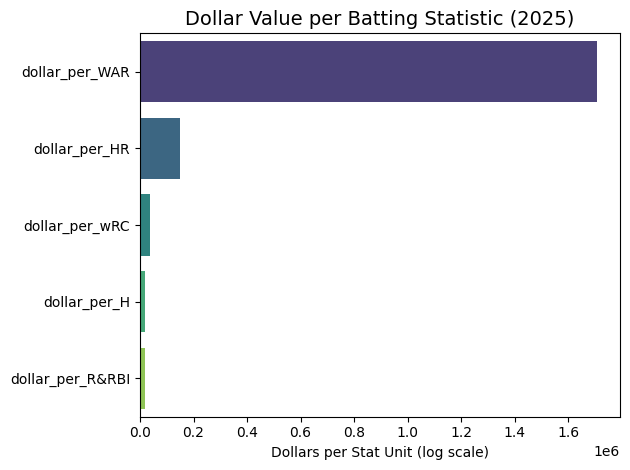

In [ ]:
player_value_stats = [
    "WAR",
    "H",
    "HR",
    "R&RBI",
    "wRC",
    "WAR"
]

average_batter_values = compile_average_player_values(player_value_stats, batters_stats_2025)

df = pd.DataFrame(list(average_batter_values.items()), columns=["Metric", "Dollar per Stat"])

sns.barplot(
    data=df.sort_values("Dollar per Stat", ascending=False),
    x="Dollar per Stat", y="Metric", palette="viridis"
)

plt.title("Dollar Value per Batting Statistic (2025)", fontsize=14)
plt.xlabel("Dollars per Stat Unit")
plt.ylabel("")
plt.tight_layout()
plt.show()

C:\Users\bengu\AppData\Local\Temp\ipykernel_19716\2570819260.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


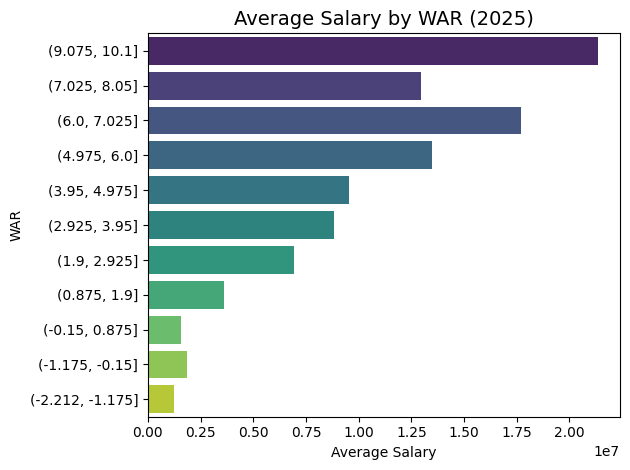

In [ ]:
salary_by_war = {}

batters_stats_2025["WAR_binned"] = pd.cut(batters_stats_2025["WAR"], 12)
salary_by_war_grouped_df = batters_stats_2025.groupby("WAR_binned")["salary"].mean().fillna(0)

for bin in batters_stats_2025["WAR_binned"].unique():
    salary_by_war[bin] = salary_by_war_grouped_df[bin]


df = pd.DataFrame(list(salary_by_war.items()), columns=["Metric", "Salary"])

sns.barplot(
    data=df.sort_values("Metric", ascending=False),
    x="Salary", y="Metric", palette="viridis"
)

plt.title("Average Salary by WAR (2025)", fontsize=14)
plt.xlabel("Average Salary")
plt.ylabel("WAR")
plt.tight_layout()
plt.show()

C:\Users\bengu\AppData\Local\Temp\ipykernel_19716\2545627478.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


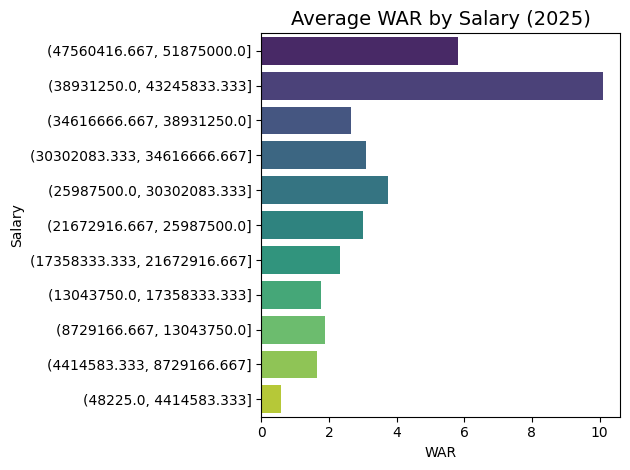

In [28]:
war_by_salary = {}

batters_stats_2025["salary_binned"] = pd.cut(batters_stats_2025["salary"], 12)
war_by_salary_grouped_df = batters_stats_2025.groupby("salary_binned")["WAR"].mean().fillna(0)

for bin in batters_stats_2025["salary_binned"].unique():
    war_by_salary[bin] = war_by_salary_grouped_df[bin]


df = pd.DataFrame(list(war_by_salary.items()), columns=["Salary", "WAR"])

sns.barplot(
    data=df.sort_values("Salary", ascending=False),
    x="WAR", y="Salary", palette="viridis"
)

plt.title("Average WAR by Salary (2025)", fontsize=14)
plt.xlabel("WAR")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

### Analyze pitcher performance per salary


In [8]:
pitchers_stats_2025 = py_baseball.pitcher.stats(start_season=2025, qual=1)
# Used to obtain the player salaries
bwar_keep_cols = ["name_common", "mlb_ID", "year_ID", "team_ID", "salary"]
pitchers_bwar_2025 = py_baseball.pitcher.bref_war()
pitchers_bwar_2025 = pitchers_bwar_2025[bwar_keep_cols]

2025-11-10 21:34:02,859 -    DEBUG - urllib3.connectionpool(20668) - Starting new HTTPS connection (1): www.fangraphs.com:443
2025-11-10 21:34:05,536 -    DEBUG - urllib3.connectionpool(20668) - https://www.fangraphs.com:443 "GET /leaders-legacy.aspx?pos=all&stats=pit&lg=all&qual=1&type=c%2C-1%2C3%2C4%2C5%2C6%2C7%2C8%2C9%2C10%2C11%2C12%2C13%2C14%2C15%2C16%2C17%2C18%2C19%2C20%2C21%2C22%2C23%2C24%2C25%2C26%2C27%2C28%2C29%2C30%2C31%2C32%2C33%2C34%2C35%2C36%2C37%2C38%2C39%2C40%2C41%2C42%2C43%2C44%2C45%2C46%2C47%2C48%2C49%2C50%2C51%2C52%2C53%2C54%2C55%2C56%2C57%2C58%2C59%2C60%2C61%2C62%2C63%2C64%2C65%2C66%2C67%2C68%2C69%2C70%2C71%2C72%2C73%2C74%2C75%2C76%2C77%2C78%2C79%2C80%2C81%2C82%2C83%2C84%2C85%2C86%2C87%2C88%2C89%2C90%2C91%2C92%2C93%2C94%2C95%2C96%2C97%2C98%2C99%2C100%2C101%2C102%2C103%2C104%2C105%2C106%2C107%2C108%2C109%2C110%2C111%2C112%2C113%2C114%2C115%2C116%2C117%2C118%2C119%2C120%2C121%2C122%2C123%2C124%2C125%2C126%2C127%2C128%2C129%2C130%2C131%2C132%2C133%2C134%2C135%2C136%2C137

In [10]:
pitchers_stats_2025 = (
    pitchers_stats_2025
    .merge(
        pitchers_bwar_2025,
        how="left",
        left_on=["Name", "Team", "Season"],
        right_on=["name_common", "team_ID", "year_ID"]
    )
    .drop(
        ["name_common", "year_ID", "team_ID"],
        axis=1
    )
)


# For now assume that na values are league minimum
league_minimum = salary.league_minimum_salaries(2025)
pitchers_stats_2025["salary"] = pitchers_stats_2025["salary"].fillna(np.float64(league_minimum))

2025-11-10 21:34:38,959 -    DEBUG - matplotlib.pyplot(20668) - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-11-10 21:34:38,965 -    DEBUG - matplotlib.pyplot(20668) - Loaded backend module://matplotlib_inline.backend_inline version unknown.


2025-11-10 21:34:38,973 -    DEBUG - matplotlib.font_manager(20668) - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-11-10 21:34:38,973 -    DEBUG - matplotlib.font_manager(20668) - findfont: score(FontEntry(fname='c:\\Users\\bengu\\.virtualenvs\\cfeproj-oIABPDjj\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-11-10 21:34:38,979 -    DEBUG - matplotlib.font_manager(20668) - findfont: score(FontEntry(fname='c:\\Users\\bengu\\.virtualenvs\\cfeproj-oIABPDjj\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-11-10 21:34:38,983 -    DEBUG - matplotlib.font_manager(20668) - findfont: score(FontEntry(fname='c:\\Users\\bengu\\.virtualenvs\\cfeproj-o

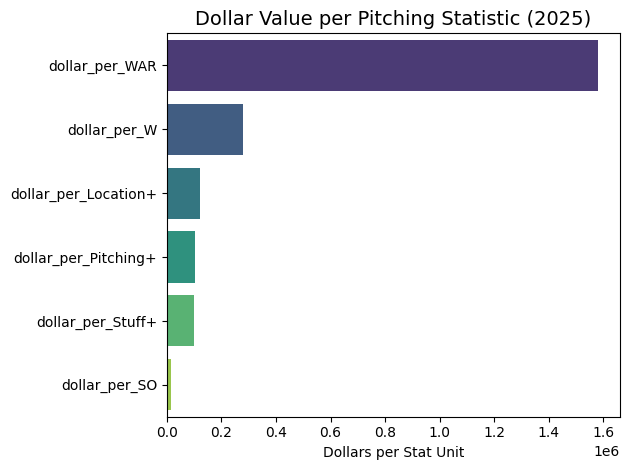

In [11]:
player_value_stats = [
    "WAR",
    "W", 
    "SO",
    "Stuff+",
    "Location+",
    "Pitching+"
]

average_pitcher_values = compile_average_player_values(player_value_stats, pitchers_stats_2025)

df = pd.DataFrame(list(average_pitcher_values.items()), columns=["Metric", "Dollar per Stat"])

sns.barplot(
    data=df.sort_values("Dollar per Stat", ascending=False),
    x="Dollar per Stat", y="Metric", palette="viridis"
)

plt.title("Dollar Value per Pitching Statistic (2025)", fontsize=14)
plt.xlabel("Dollars per Stat Unit")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
pitchers_stats_2025

C:\Users\bengu\AppData\Local\Temp\ipykernel_19716\3597915519.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


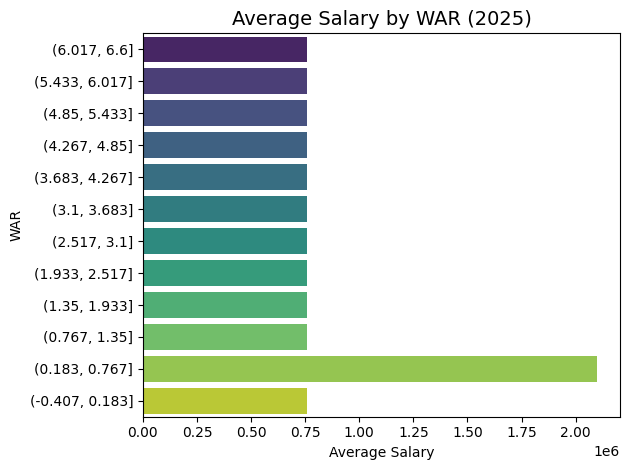

In [29]:
salary_by_war = {}

pitchers_stats_2025["WAR_binned"] = pd.cut(pitchers_stats_2025["WAR"], 12)
salary_by_war_grouped_df = pitchers_stats_2025.groupby("WAR_binned")["salary"].mean().fillna(0)

for bin in pitchers_stats_2025["WAR_binned"].unique():
    salary_by_war[bin] = salary_by_war_grouped_df[bin]


df = pd.DataFrame(list(salary_by_war.items()), columns=["Metric", "Salary"])

sns.barplot(
    data=df.sort_values("Metric", ascending=False),
    x="Salary", y="Metric", palette="viridis"
)

plt.title("Average Salary by WAR (2025)", fontsize=14)
plt.xlabel("Average Salary")
plt.ylabel("WAR")
plt.tight_layout()
plt.show()

C:\Users\bengu\AppData\Local\Temp\ipykernel_19716\1946236700.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


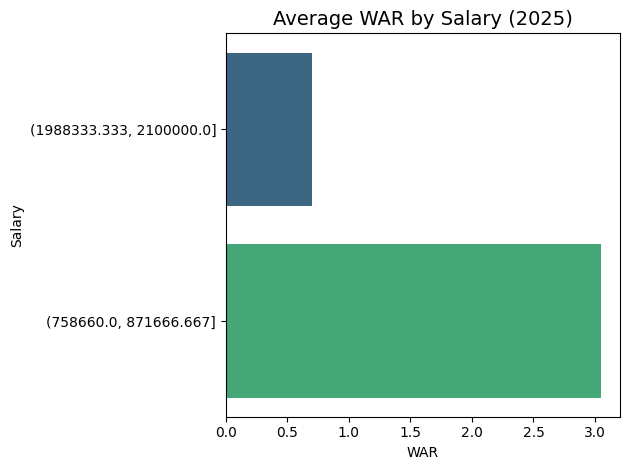

In [32]:
war_by_salary = {}

pitchers_stats_2025["salary_binned"] = pd.cut(pitchers_stats_2025["salary"], 12)
war_by_salary_grouped_df = pitchers_stats_2025.groupby("salary_binned")["WAR"].mean().fillna(0)

for bin in pitchers_stats_2025["salary_binned"].unique():
    war_by_salary[bin] = war_by_salary_grouped_df[bin]


df = pd.DataFrame(list(war_by_salary.items()), columns=["Salary", "WAR"])

sns.barplot(
    data=df.sort_values("Salary", ascending=False),
    x="WAR", y="Salary", palette="viridis"
)

plt.title("Average WAR by Salary (2025)", fontsize=14)
plt.xlabel("WAR")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()